# 2. A Stochastic Dealer Model I
<br>

# 2.1. Preperation

In [1]:
% matplotlib inline
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)

In [2]:
# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:])-np.log(St[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return ((data)/np.sqrt(np.var(data)))
# compute normalized probability distribution function
def pdf(data,bins=50):
    hist,edges=np.histogram(data[~np.isnan(data)],bins=bins,density=True) # remove NaNs and compute histogram
    edges   = (edges[:-1] + edges[1:])/2.0 # get bar center
    nonzero = hist > 0.0                   # non-zero points 
    return edges[nonzero], hist[nonzero]

# 2.2. The Dealer Model
<!--
<img src="fig/dealers0.svg" width=1000>
-->
![](fig/dealers0.png)

- K. Yamada, H. Takayasu, T. Ito and M. Takayasu, <i>Physical Revew E</i> <b>79</b>, 051120 (2009).
- Simple Stochastic model with only two dealers offering buying and selling options.
- The mid-price $p_i(t)$ of dealer $i$ at time $t$ is the average of his bid and ask price.
$$
	\lvert p_i(t) - p_j(t) \rvert \ge L\tag{K1} : \textrm{Transaction Criterion}	
$$

# 2.3. Dynamics of the dealer model
<!--
<img src="fig/dealers.svg" width=1000>
-->
![](fig/dealers.png)

- Prices carry out a 1D random walk in 'price' space until a transaction takes place.
$$
p_i(t + \Delta t) = p_i(t) + c f_i(t), \qquad \qquad i=1,2\tag{K2}\\
$$
$$
f_i(t) = \begin{cases}
    +\Delta p & \mathrm{probability} 1/2 \\
    -\Delta p & \mathrm{probability} 1/2
\end{cases}
$$
- The "Market" price $P$ of a transaction is given by the average of the mid-prices 
$$P = (p_1 + p_2)/2\tag{K3}$$

# 2.4. Dealer model as a 2D random walk
- The dealer model can be understood as a standard 2D Random walk with absorbing boundaries.
- Perform a change in variables, from $p_1(t)$ and $p_2(t)$, to the price difference $D(t)$ and average $A(t)$
$$
D(t) = p_1(t) - p_2(t) \tag{K4}
$$
$$
A(t) = \frac{1}{2}\big(p_1(t) + p_2(t)\big)\tag{K5}
$$
- Dynamics of $D$ and $A$ describe a 2D random walk
$$
D(t+\Delta t) = D(t) + \begin{cases}
+2 c \Delta p & \textrm{probability 1/4} \\
0 & \textrm{probability 1/2} \\
-2 c\Delta p& \textrm{probability 1/4}
\end{cases} \tag{K6} \\
$$
$$
A(t+\Delta t) = A(t) + \begin{cases}
+c\Delta p & \textrm{probability 1/4}\\
0 & \textrm{probability 1/2}\\
-c\Delta p &\textrm{probability 1/4}
\end{cases}\tag{K7}
$$
- When $D(t) = \pm L$ a transaction occurs and the random walk ends, the "particle" is absorbed by the boundary.

In [3]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2} # define model parameters
def model1RW(params,p0):                # simulate Random-Walk for 1 transaction
    price = np.array([p0[0], p0[1]])    # initialize mid-prices for dealers p_1 and p_2
    cdp   = params['c']*params['dp']    # define random step size
    Dt    = [price[0]-price[1]]         # initialize price difference as empty list
    At    = [np.average(price)]         # initialize avg price as empy list
    while np.abs(price[0]-price[1]) < params['L']:
        price=price+np.random.choice([-cdp,cdp],size=2) # random walk step for mid-prices Eq. (K2)
        Dt.append(price[0]-price[1])
        At.append(np.average(price))
    return np.array(Dt),np.array(At)-At[0] # return difference array and average centered at zero

Walk  0  : number of steps =  9248 , price change =  -0.00270000000009
Walk  1  : number of steps =  2201 , price change =  0.00340000000011
Walk  2  : number of steps =  1629 , price change =  0.00280000000009


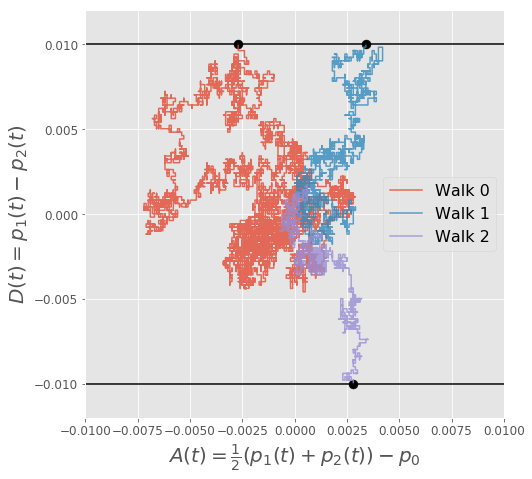

In [4]:
np.random.seed(123456)
fig,ax=plt.subplots(figsize=(7.5,7.5),subplot_kw={'xlabel':r'$A(t) = \frac{1}{2}\left(p_1(t) + p_2(t)\right) - p_0$', 'ylabel':r'$D(t) = p_1(t) - p_2(t)$'})
p0 = [100.25, 100.25]
for i in range(3):
    Dt,At = model1RW(params, p0)
    ax.plot(At,Dt,alpha=0.8,label='Walk '+str(i)) #plot random walk trajectory
    ax.scatter(At[-1],Dt[-1],marker='o',s=80,color='k') #last point
    print('Walk ', i,' : number of steps = ',len(At),', price change = ', At[-1])
ax.plot([-0.01,0.03],[params['L'],params['L']],color='k') #top absorbing boundary P=L
ax.plot([-0.01,0.03],[-params['L'],-params['L']],color='k') #bottom absorbing boundary P=-L
ax.set_ylim([-0.012, 0.012])
ax.set_xlim([-0.01, 0.01])
ax.legend(loc=5,framealpha=0.8)
plt.show()

# 2.5. Perform simulations

In [5]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2} # define model parameters
def model1(params,p0,numt):                # simulate dealer model for numt ticks
    mktprice = np.zeros(numt)              # initialize array for market prices
    ticktime = np.zeros(numt,dtype=np.int) # initialize array for tick times
    price    = np.array([p0[0], p0[1]])    # initailize dealer's mid-price (p1,p2)
    time,tick = 0,0                        # real time (t) and tick time (n)
    cdp      = params['c']*params['dp']    # define random step size
    while tick < numt:                     # loop over ticks
        while np.abs(price[0]-price[1])< params['L']: # perform one RW for each transaction
            price=price+np.random.choice([-cdp,cdp],size=2) # random walk step Eq. (K2)
            time += 1 # update time t
        price[:] = np.average(price)       # set mid-prices to new market price Eq. (K3)
        mktprice[tick] = price[0]          # save market price
        ticktime[tick] = time              # save tick time
        tick += 1                          # updat ticks
    return ticktime,mktprice   

- A simulation is performed if you run the cell below, but depending on your computer power it may take quite long time until it finishes with properly creating the simulation data "model1.txt".
- You may skip this cell and use pre-calculated simulation data "model1.txt" which can be downloaded from our website to continue further data analyses.

In [ ]:
np.random.seed(0)
ticktime,mktprice=model1(params,[100.25,100.25],5000)
np.savetxt('model1.txt',np.transpose([ticktime,mktprice]))

# 2.6. Analyses

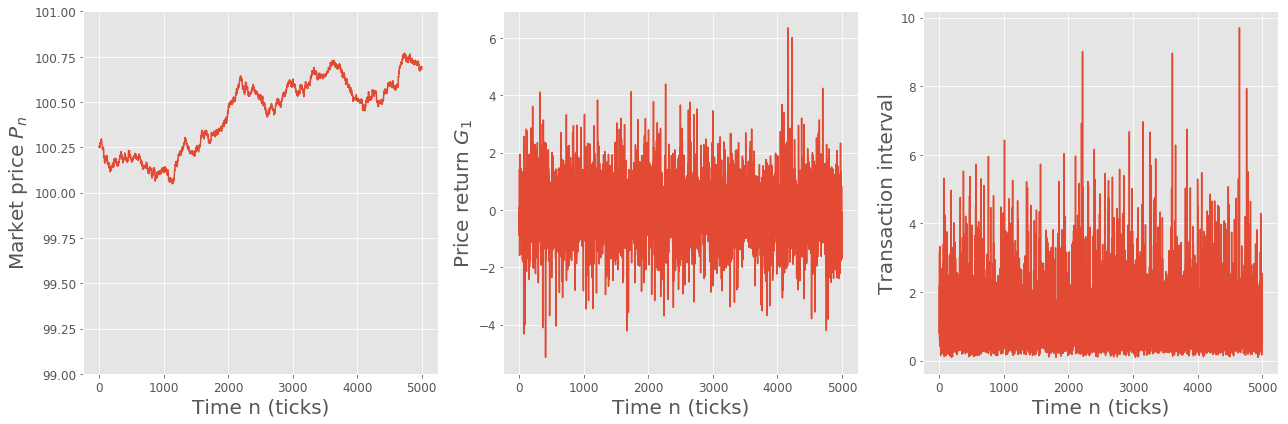

In [6]:
ticktime,mktprice=np.loadtxt('model1.txt',unpack=True) # read saved data from file
timeinterval=normalized((ticktime[1:]-ticktime[0:-1])*params['dt']) # compute time difference between subsequent trades
dprice=normalized(logreturn(mktprice,1)) # compute logarithmic return of the price over one tick, normalized to have unit variance (Eq. J2)
fig,[ax,bx,cx]=plt.subplots(figsize=(18,6),ncols=3,subplot_kw={'xlabel':r'Time n (ticks)'})
ax.plot(mktprice)
ax.set_ylim(99,101)
ax.set_ylabel(r'Market price $P_n$')
bx.plot(dprice)
bx.set_ylabel(r'Price return $G_1$')
cx.plot(timeinterval)
cx.set_ylabel(r'Transaction interval')
fig.tight_layout() # get nice spacing between plots
plt.show()

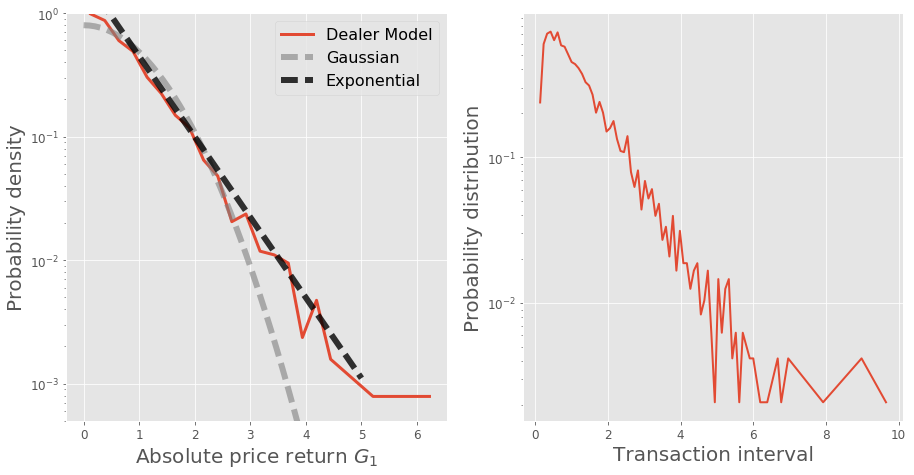

In [7]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'ylabel':r'Probability distribution'})
edges,hist=pdf(np.abs(dprice),bins=25) # probability density of price change G_1 between ticks
ax.plot(edges, hist, lw=3, label='Dealer Model')
x = np.linspace(0, 5)
ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls='--',color='gray',alpha=0.6,label=r'Gaussian')
ax.plot(x, 2*np.exp(-1.5*x),lw=6,color='k',ls='--',alpha=0.8,label=r'Exponential')
ax.set_xlabel(r'Absolute price return $G_1$')
ax.set_ylabel(r'Probability density')
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.legend()
edges,hist=pdf(timeinterval,bins=100) # probability density of transaction time intervals between ticks
bx.plot(edges,hist, lw=2)
bx.set_xlabel(r'Transaction interval')
bx.set_ylabel(r'Probability distribution')
bx.semilogy()
plt.show()